In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
# from sklearn.preprocessing import normalize
# import scipy.cluster.hierarchy as shc
# from sklearn.cluster import AgglomerativeClustering

/Users/yeeeeehan/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# read in dataset and select columns

l = pd.read_csv('labelled.csv')
u = pd.read_csv('unlabelled.csv')

/Users/yeeeeehan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (62,63,64,80,95,97) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/yeeeeehan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5,32,34,54,55,56,62,63,64,77,80,95,97,115,116,122) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
labelled = l.set_index('eventid')
unlabelled = u.set_index('eventid')

In [4]:
# Distribution of labelled and unlabelled rows by year 

print(f"Number of rows in labelled: {labelled.shape[0]}")
print(f"Number of rows in unlabelled: {unlabelled.shape[0]}")
print(f"# of rows in labelled as a % of # of rows in unlabelled: {round(labelled.shape[0]/unlabelled.shape[0] * 100, 2)}%\n")

year_distribution = labelled["iyear"].value_counts().to_frame().join(unlabelled["iyear"].value_counts(), lsuffix = "_left").sort_index()
year_distribution.columns = ['labelled_year_count','unlabelled_year_count']
year_distribution['%_of_unlabelled'] = round(year_distribution['labelled_year_count'] / year_distribution['unlabelled_year_count'] * 100, 2)
print(f"Minimum value of %_of_unlabelled: {year_distribution['%_of_unlabelled'].min()}%")
print(f"Minimum value of %_of_unlabelled: {year_distribution['%_of_unlabelled'].max()}%")
year_distribution

Number of rows in labelled: 28139
Number of rows in unlabelled: 163325
# of rows in labelled as a % of # of rows in unlabelled: 17.23%

Minimum value of %_of_unlabelled: 8.7%
Minimum value of %_of_unlabelled: 34.51%


,labelled_year_count,unlabelled_year_count,%_of_unlabelled
1970,130,521,24.95
1971,56,415,13.49
1972,46,522,8.81
1973,84,389,21.59
1974,70,511,13.70
1975,64,676,9.47
1976,84,839,10.01
1977,147,1172,12.54
1978,289,1237,23.36
1979,478,2184,21.89


In [5]:
# Introduce nkillwound column

labelled['nkillwound'] = labelled['nkill'] + labelled['nwound']
unlabelled['nkillwound'] = unlabelled['nkill'] + unlabelled['nwound']

In [6]:
# Specifying columns to perform ML on

cols_for_learning = ['region','attacktype1','targtype1','weaptype1', 'cluster']

extra_cols = ['extended', 'success', 'suicide', #'property'
]

In [7]:
# Convert all fields to int from float 
labelled = labelled[cols_for_learning].astype('int32')
unlabelled = unlabelled[cols_for_learning[:-1]].astype('int32')

In [8]:
labelled.head()

,region,attacktype1,targtype1,weaptype1,cluster
eventid,,,,,
197000000002,1,6,7,13,2
197001020001,3,1,3,5,2
197001020003,1,7,4,8,2
197001030001,1,7,2,8,2
197001080001,8,4,6,5,2


In [9]:
####Model building

import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils


from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [10]:
percentage_split = 0.8
# max_words = 1000
batch_size = 10000
epochs = 500

labelled = labelled.sample(frac=1) # Shuffle labelled set

columns = labelled[['region','attacktype1','targtype1','weaptype1']].to_numpy()
clusters = labelled['cluster'].to_numpy()

num_classes = np.max(clusters) - np.min(clusters) + 1
clusters = utils.to_categorical(clusters, num_classes)

train_size = int(len(labelled) * percentage_split) 

x_train = columns[:train_size]
y_train = clusters[:train_size]

x_eval = columns[train_size:]
y_eval = clusters[train_size:]

Epoch 1/500
2/2 [==============================] - 0s 112ms/step - loss: 1.7642 - accuracy: 0.2420 - val_loss: 1.3157 - val_accuracy: 0.4295
Epoch 2/500
2/2 [==============================] - 0s 38ms/step - loss: 1.5557 - accuracy: 0.3161 - val_loss: 1.3363 - val_accuracy: 0.4066
Epoch 3/500
2/2 [==============================] - 0s 35ms/step - loss: 1.5771 - accuracy: 0.3490 - val_loss: 1.3423 - val_accuracy: 0.4085
Epoch 4/500
2/2 [==============================] - 0s 34ms/step - loss: 1.5425 - accuracy: 0.3634 - val_loss: 1.2766 - val_accuracy: 0.4104
Epoch 5/500
2/2 [==============================] - 0s 34ms/step - loss: 1.4794 - accuracy: 0.3668 - val_loss: 1.2295 - val_accuracy: 0.4286
Epoch 6/500
2/2 [==============================] - 0s 33ms/step - loss: 1.4468 - accuracy: 0.3713 - val_loss: 1.2232 - val_accuracy: 0.4555
Epoch 7/500
2/2 [==============================] - 0s 35ms/step - loss: 1.4412 - accuracy: 0.3630 - val_loss: 1.2262 - val_accuracy: 0.4491
Epoch 8/500
2/2 [==

2/2 [==============================] - 0s 30ms/step - loss: 1.1868 - accuracy: 0.4995 - val_loss: 1.1472 - val_accuracy: 0.5065
Epoch 60/500
2/2 [==============================] - 0s 29ms/step - loss: 1.1895 - accuracy: 0.4950 - val_loss: 1.1466 - val_accuracy: 0.5073
Epoch 61/500
2/2 [==============================] - 0s 29ms/step - loss: 1.1852 - accuracy: 0.4973 - val_loss: 1.1458 - val_accuracy: 0.5063
Epoch 62/500
2/2 [==============================] - 0s 29ms/step - loss: 1.1792 - accuracy: 0.5015 - val_loss: 1.1450 - val_accuracy: 0.5060
Epoch 63/500
2/2 [==============================] - 0s 29ms/step - loss: 1.1856 - accuracy: 0.4978 - val_loss: 1.1442 - val_accuracy: 0.5050
Epoch 64/500
2/2 [==============================] - 0s 29ms/step - loss: 1.1817 - accuracy: 0.4926 - val_loss: 1.1433 - val_accuracy: 0.5067
Epoch 65/500
2/2 [==============================] - 0s 29ms/step - loss: 1.1837 - accuracy: 0.4987 - val_loss: 1.1426 - val_accuracy: 0.5075
Epoch 66/500
2/2 [========

Epoch 117/500
2/2 [==============================] - 0s 30ms/step - loss: 1.1482 - accuracy: 0.5088 - val_loss: 1.1211 - val_accuracy: 0.5200
Epoch 118/500
2/2 [==============================] - 0s 34ms/step - loss: 1.1476 - accuracy: 0.5086 - val_loss: 1.1207 - val_accuracy: 0.5205
Epoch 119/500
2/2 [==============================] - 0s 33ms/step - loss: 1.1438 - accuracy: 0.5132 - val_loss: 1.1203 - val_accuracy: 0.5207
Epoch 120/500
2/2 [==============================] - 0s 32ms/step - loss: 1.1476 - accuracy: 0.5090 - val_loss: 1.1200 - val_accuracy: 0.5207
Epoch 121/500
2/2 [==============================] - 0s 37ms/step - loss: 1.1449 - accuracy: 0.5121 - val_loss: 1.1197 - val_accuracy: 0.5213
Epoch 122/500
2/2 [==============================] - 0s 34ms/step - loss: 1.1414 - accuracy: 0.5148 - val_loss: 1.1195 - val_accuracy: 0.5224
Epoch 123/500
2/2 [==============================] - 0s 31ms/step - loss: 1.1466 - accuracy: 0.5133 - val_loss: 1.1190 - val_accuracy: 0.5231
Epoch 

Epoch 175/500
2/2 [==============================] - 0s 33ms/step - loss: 1.1289 - accuracy: 0.5209 - val_loss: 1.1052 - val_accuracy: 0.5330
Epoch 176/500
2/2 [==============================] - 0s 36ms/step - loss: 1.1319 - accuracy: 0.5171 - val_loss: 1.1052 - val_accuracy: 0.5333
Epoch 177/500
2/2 [==============================] - 0s 30ms/step - loss: 1.1298 - accuracy: 0.5231 - val_loss: 1.1053 - val_accuracy: 0.5332
Epoch 178/500
2/2 [==============================] - 0s 31ms/step - loss: 1.1328 - accuracy: 0.5199 - val_loss: 1.1051 - val_accuracy: 0.5304
Epoch 179/500
2/2 [==============================] - 0s 40ms/step - loss: 1.1294 - accuracy: 0.5200 - val_loss: 1.1048 - val_accuracy: 0.5308
Epoch 180/500
2/2 [==============================] - 0s 39ms/step - loss: 1.1319 - accuracy: 0.5201 - val_loss: 1.1045 - val_accuracy: 0.5312
Epoch 181/500
2/2 [==============================] - 0s 31ms/step - loss: 1.1281 - accuracy: 0.5219 - val_loss: 1.1044 - val_accuracy: 0.5310
Epoch 

Epoch 233/500
2/2 [==============================] - 0s 48ms/step - loss: 1.1207 - accuracy: 0.5251 - val_loss: 1.0955 - val_accuracy: 0.5390
Epoch 234/500
2/2 [==============================] - 0s 45ms/step - loss: 1.1153 - accuracy: 0.5321 - val_loss: 1.0951 - val_accuracy: 0.5349
Epoch 235/500
2/2 [==============================] - 0s 46ms/step - loss: 1.1200 - accuracy: 0.5274 - val_loss: 1.0947 - val_accuracy: 0.5371
Epoch 236/500
2/2 [==============================] - 0s 45ms/step - loss: 1.1167 - accuracy: 0.5282 - val_loss: 1.0947 - val_accuracy: 0.5415
Epoch 237/500
2/2 [==============================] - 0s 48ms/step - loss: 1.1165 - accuracy: 0.5308 - val_loss: 1.0945 - val_accuracy: 0.5430
Epoch 238/500
2/2 [==============================] - 0s 47ms/step - loss: 1.1151 - accuracy: 0.5253 - val_loss: 1.0945 - val_accuracy: 0.5349
Epoch 239/500
2/2 [==============================] - 0s 43ms/step - loss: 1.1174 - accuracy: 0.5243 - val_loss: 1.0945 - val_accuracy: 0.5361
Epoch 

Epoch 291/500
2/2 [==============================] - 0s 47ms/step - loss: 1.1119 - accuracy: 0.5314 - val_loss: 1.0882 - val_accuracy: 0.5458
Epoch 292/500
2/2 [==============================] - 0s 44ms/step - loss: 1.1099 - accuracy: 0.5327 - val_loss: 1.0879 - val_accuracy: 0.5466
Epoch 293/500
2/2 [==============================] - 0s 33ms/step - loss: 1.1093 - accuracy: 0.5297 - val_loss: 1.0881 - val_accuracy: 0.5382
Epoch 294/500
2/2 [==============================] - 0s 32ms/step - loss: 1.1127 - accuracy: 0.5290 - val_loss: 1.0880 - val_accuracy: 0.5461
Epoch 295/500
2/2 [==============================] - 0s 28ms/step - loss: 1.1092 - accuracy: 0.5331 - val_loss: 1.0876 - val_accuracy: 0.5453
Epoch 296/500
2/2 [==============================] - 0s 29ms/step - loss: 1.1112 - accuracy: 0.5336 - val_loss: 1.0880 - val_accuracy: 0.5450
Epoch 297/500
2/2 [==============================] - 0s 28ms/step - loss: 1.1090 - accuracy: 0.5314 - val_loss: 1.0882 - val_accuracy: 0.5462
Epoch 

Epoch 349/500
2/2 [==============================] - 0s 34ms/step - loss: 1.1049 - accuracy: 0.5345 - val_loss: 1.0831 - val_accuracy: 0.5464
Epoch 350/500
2/2 [==============================] - 0s 28ms/step - loss: 1.1069 - accuracy: 0.5327 - val_loss: 1.0831 - val_accuracy: 0.5454
Epoch 351/500
2/2 [==============================] - 0s 28ms/step - loss: 1.1083 - accuracy: 0.5329 - val_loss: 1.0833 - val_accuracy: 0.5461
Epoch 352/500
2/2 [==============================] - 0s 30ms/step - loss: 1.1072 - accuracy: 0.5304 - val_loss: 1.0833 - val_accuracy: 0.5466
Epoch 353/500
2/2 [==============================] - 0s 30ms/step - loss: 1.1065 - accuracy: 0.5346 - val_loss: 1.0832 - val_accuracy: 0.5476
Epoch 354/500
2/2 [==============================] - 0s 29ms/step - loss: 1.1061 - accuracy: 0.5372 - val_loss: 1.0831 - val_accuracy: 0.5464
Epoch 355/500
2/2 [==============================] - 0s 29ms/step - loss: 1.1050 - accuracy: 0.5339 - val_loss: 1.0829 - val_accuracy: 0.5462
Epoch 

Epoch 407/500
2/2 [==============================] - 0s 38ms/step - loss: 1.1024 - accuracy: 0.5359 - val_loss: 1.0796 - val_accuracy: 0.5489
Epoch 408/500
2/2 [==============================] - 0s 33ms/step - loss: 1.1042 - accuracy: 0.5361 - val_loss: 1.0796 - val_accuracy: 0.5488
Epoch 409/500
2/2 [==============================] - 0s 30ms/step - loss: 1.0996 - accuracy: 0.5420 - val_loss: 1.0791 - val_accuracy: 0.5511
Epoch 410/500
2/2 [==============================] - 0s 37ms/step - loss: 1.1007 - accuracy: 0.5378 - val_loss: 1.0788 - val_accuracy: 0.5511
Epoch 411/500
2/2 [==============================] - 0s 31ms/step - loss: 1.0994 - accuracy: 0.5387 - val_loss: 1.0788 - val_accuracy: 0.5503
Epoch 412/500
2/2 [==============================] - 0s 29ms/step - loss: 1.1029 - accuracy: 0.5359 - val_loss: 1.0788 - val_accuracy: 0.5492
Epoch 413/500
2/2 [==============================] - 0s 29ms/step - loss: 1.1006 - accuracy: 0.5381 - val_loss: 1.0790 - val_accuracy: 0.5491
Epoch 

Epoch 465/500
2/2 [==============================] - 0s 51ms/step - loss: 1.0971 - accuracy: 0.5428 - val_loss: 1.0760 - val_accuracy: 0.5528
Epoch 466/500
2/2 [==============================] - 0s 40ms/step - loss: 1.0968 - accuracy: 0.5381 - val_loss: 1.0759 - val_accuracy: 0.5499
Epoch 467/500
2/2 [==============================] - 0s 30ms/step - loss: 1.0968 - accuracy: 0.5379 - val_loss: 1.0757 - val_accuracy: 0.5535
Epoch 468/500
2/2 [==============================] - 0s 32ms/step - loss: 1.0983 - accuracy: 0.5426 - val_loss: 1.0758 - val_accuracy: 0.5522
Epoch 469/500
2/2 [==============================] - 0s 29ms/step - loss: 1.0989 - accuracy: 0.5401 - val_loss: 1.0757 - val_accuracy: 0.5497
Epoch 470/500
2/2 [==============================] - 0s 29ms/step - loss: 1.0982 - accuracy: 0.5399 - val_loss: 1.0755 - val_accuracy: 0.5567
Epoch 471/500
2/2 [==============================] - 0s 32ms/step - loss: 1.0971 - accuracy: 0.5387 - val_loss: 1.0754 - val_accuracy: 0.5563
Epoch 

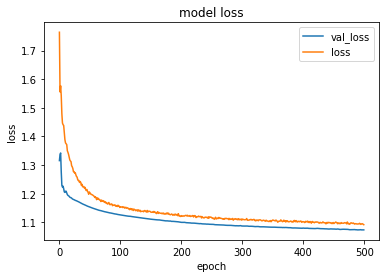

In [11]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(len(columns[0]),)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.33)

def display_training_graph(history):
    # summarize history for loss
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'loss'], loc='upper right')
    plt.draw()


display_training_graph(history)

In [12]:
#Evaluation
evaluation_score = model.evaluate(x_eval, y_eval,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', evaluation_score[1])

1/1 [==============================] - 0s 2ms/step - loss: 1.0944 - accuracy: 0.5434
Test accuracy: 0.5433546304702759


In [13]:
y_predicted = model.predict(x_eval)
y_predicted = y_predicted.max(axis=1,keepdims=1) == y_predicted

y_predicted_arr = []
for x in y_predicted:
    y_predicted_arr.append(np.where(x == True)[0][0])
    
np.array(y_predicted_arr)


y_eval_arr = []
for x in y_eval:
    y_eval_arr.append(np.where(x == 1.0)[0][0])
    
print(confusion_matrix(np.array(y_predicted_arr), np.array(y_eval_arr)))

[[1016  143  336  260]
 [ 322  766  292  370]
 [ 235  320 1215  185]
 [  40   20   47   61]]


In [14]:
# Predict on unknown data set
x_test = unlabelled[['region','attacktype1','targtype1','weaptype1']].to_numpy()
y_test = model.predict(x_test)
y_test = y_test.max(axis=1,keepdims=1) == y_test

y_test_arr = []
for x in y_test:
    y_test_arr.append(np.where(x == True)[0][0])

In [15]:
# Joining unlabelled with labelled
u['cluster'] = y_test_arr

l['cluster'] = l['cluster'].astype('int32')
result = pd.concat([u, l], axis=0, join='outer', ignore_index=False, keys='eventid',
          levels=None, names=None, verify_integrity=False, copy=True)

In [16]:
result.head(30)

Unnamed: 0       eventid  iyear  imonth  iday           approxdate  \
e 0            0  197000000001   1970       7     2                  NaN   
  1            2  197001000001   1970       1     0                  NaN   
  2            3  197001000002   1970       1     0                  NaN   
  3            4  197001000003   1970       1     0                  NaN   
  4            5  197001010002   1970       1     1                  NaN   
  5            7  197001020002   1970       1     2                  NaN   
  6           10  197001050001   1970       1     1                  NaN   
  7           11  197001060001   1970       1     6                  NaN   
  8           13  197001090001   1970       1     9                  NaN   
  9           14  197001090002   1970       1     9                  NaN   
  10          15  197001100001   1970       1    10                  NaN   
  11          17  197001120001   1970       1    12                  NaN   
  12          18  197001120002   1970       1    12                  NaN   
  13          19  197001130001   1970       1    13                  NaN   
  14          20  197001140001   1970       1    14                  NaN   
  15          24  197001190004   1970       1    19  January 19-20, 1970   
  16          26  197001210001   1970       1    21                  NaN   
  17          28  197001220002   1970       1    22                  NaN   
  18          29  197001250001   1970       1    25                  NaN   
  19          30  197001250002   1970       1    25                  NaN   
  20          31  197001260001   1970       1    26                  NaN   
  21          32  197001260003   1970       1    26                  NaN   
  22          33  197001270002   1970       1    27                  NaN   
  23          34  197001280001   1970       1    28                  NaN   
  24          35  197001280002   1970       1    28                  NaN   
  25          36  197001300001   1970       1    30                  NaN   
  26          37  197001300002   1970       1    30                  NaN   
  27          38  197001300003   1970       1    30                  NaN   
  28          39  197001310001   1970       1    31                  NaN   
  29          40  197001310002   1970       1    31                  NaN   

      extended resolution  country         country_txt  ...  \
e 0          0        NaN       58  Dominican Republic  ...   
  1          0        NaN      160         Philippines  ...   
  2          0        NaN       78              Greece  ...   
  3          0        NaN      101               Japan  ...   
  4          0        NaN      217       United States  ...   
  5          0        NaN      217       United States  ...   
  6          0        NaN      217       United States  ...   
  7          0        NaN      217       United States  ...   
  8          0        NaN      217       United States  ...   
  9          0        NaN      217       United States  ...   
  10         0        NaN      499  East Germany (GDR)  ...   
  11         0        NaN      217       United States  ...   
  12         0        NaN      217       United States  ...   
  13         0        NaN      217       United States  ...   
  14         0        NaN      217       United States  ...   
  15         0        NaN      217       United States  ...   
  16         0        NaN      160         Philippines  ...   
  17         0        NaN      217       United States  ...   
  18         0        NaN      217       United States  ...   
  19         0        NaN      217       United States  ...   
  20         0        NaN      217       United States  ...   
  21         0        NaN      217       United States  ...   
  22         0        NaN      217       United States  ...   
  23         0        NaN      499  East Germany (GDR)  ...   
  24         0        NaN      217       United States  ...   
  25       

In [ ]:
# result.to_csv('result.csv')

In [ ]:
result.shape